In [1]:
import argparse
import logging
import sys
import torch
import json
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
torch.manual_seed(0)

In [27]:
from advertorch.test_utils import LeNet5
from advertorch_examples.utils import TRAINED_MODEL_PATH

filename = "mnist_lenet5_clntrained.pt"

model = LeNet5()
model.load_state_dict(
    torch.load(os.path.join(TRAINED_MODEL_PATH, filename))
)

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

# model.to(device)
model.eval()

LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=200, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

In [16]:
os.path.join(TRAINED_MODEL_PATH, filename)

'C:\\Users\\juliu\\miniconda3\\envs\\robustness_env\\lib\\site-packages\\advertorch_examples\\trained_models\\mnist_lenet5_clntrained.pt'

In [17]:
config = {}
config["model::type"] = "CNN"
config["model::channels_in"] = 1
config["model::o_dim"] = 4
config["model::nlin"] = "tanh"
config["model::dropout"] = 0.0
config["model::init_type"] = "uniform"
config["model::use_bias"] = False
config["optim::optimizer"] = "adam"
config["optim::lr"] = 0.0003
config["optim::wd"] = 0.000

In [18]:
config.get("model::type", 2)

'CNN'

In [29]:
from advertorch_examples.utils import get_mnist_test_loader
loader = get_mnist_test_loader(batch_size=5)
for cln_data, true_label in loader:
    break
# cln_data, true_label = cln_data.to(device), true_label.to(device)

In [30]:
dataset = torch.load("model_robustness/data/MNIST/dataset.pt")

In [31]:
trainset = dataset["trainset"]
testset = dataset["testset"]
valset = dataset["valset"]

trainloader = DataLoader(
    dataset=trainset,
    batch_size=5,
    shuffle=True,
)
testloader = DataLoader(
    dataset=testset,
    batch_size=5,
    shuffle=False
)
valloader = DataLoader(
    dataset=valset,
    batch_size=5,
    shuffle=False
)


In [22]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1, 64)
        self.fc_2 = nn.Linear(64, 128)
        self.fc_3 = nn.Linear(128, 10)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)

        return out

In [23]:
net = MLP()

In [32]:
for cln_data, true_label in testloader:
    pass

In [33]:
from advertorch.attacks import GradientSignAttack, LinfPGDAttack, MomentumIterativeAttack

adversary2 = MomentumIterativeAttack(model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15, nb_iter=40, eps_iter=0.01, clip_min=0.0, clip_max=1.0, targeted=False)

adversary1 = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15, targeted= False
)

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

In [34]:
# Untargeted attack - not controlling the target output
adv_untargeted = adversary2.perturb(cln_data, true_label)

In [35]:
# Targeted attack - controlling the target output (class 3 in this example)
target = torch.ones_like(true_label) * 3
adversary2.targeted = True
adv_targeted = adversary2.perturb(cln_data, target)

In [36]:
pred_untargeted

tensor([9, 1, 3, 2, 3])

In [42]:
adv_untargeted[0][0][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [40]:
cln_data[0][0][0]

tensor([-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
        -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
        -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
        -0.4241, -0.4241, -0.4241, -0.4241])

In [44]:
model(adv_targeted)[0]

tensor([ -6.8339, -13.3889,  -4.3363,   1.8488,   4.4164,  -4.2894, -13.1699,
         -0.0180,   0.9066,  14.3520], grad_fn=<SelectBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


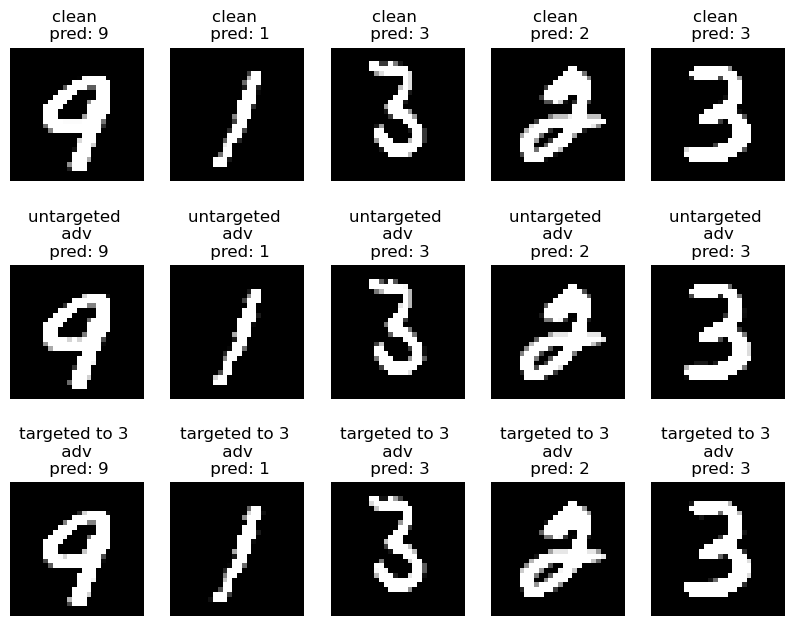

In [38]:
# Visualization of attacks
from advertorch.utils import predict_from_logits
from advertorch_examples.utils import _imshow

# net.eval()
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted = predict_from_logits(model(adv_untargeted))
pred_targeted = predict_from_logits(model(adv_targeted))

plt.figure(figsize=(10,8))
for ii in range(5):
    plt.subplot(3, 5, ii+1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3,5, ii+1+5)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(pred_untargeted[ii]))
    plt.subplot(3,5, ii+1+5*2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(pred_targeted[ii]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


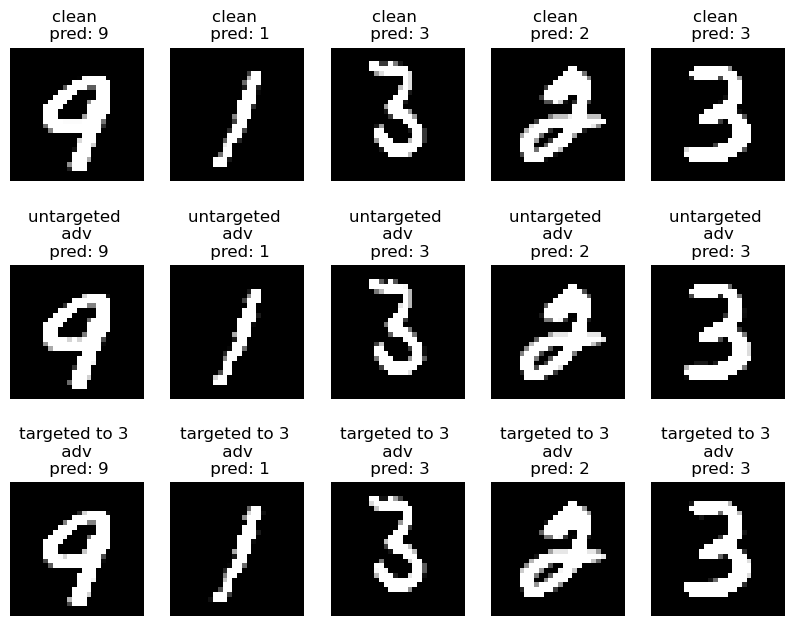

In [26]:
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted = predict_from_logits(model(adv_untargeted))
pred_targeted = predict_from_logits(model(adv_targeted))

plt.figure(figsize=(10,8))
for ii in range(5):
    plt.subplot(3, 5, ii+1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3,5, ii+1+5)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(pred_untargeted[ii]))
    plt.subplot(3,5, ii+1+5*2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(pred_targeted[ii]))

In [39]:
perturbed_data = torch.utils.data.TensorDataset(adv_untargeted, true_label)

tensor(9)


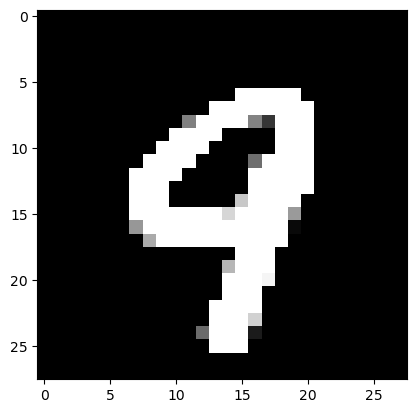

In [54]:
plt.imshow(adv_untargeted[0][0], cmap="gray")
print(true_label[0])

tensor(9)


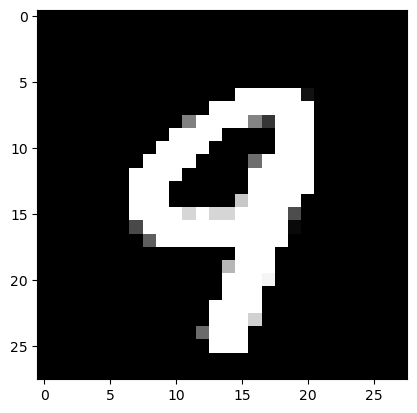

In [55]:
plt.imshow(adv_targeted[0][0], cmap="gray")
print(true_label[0])

tensor(9)


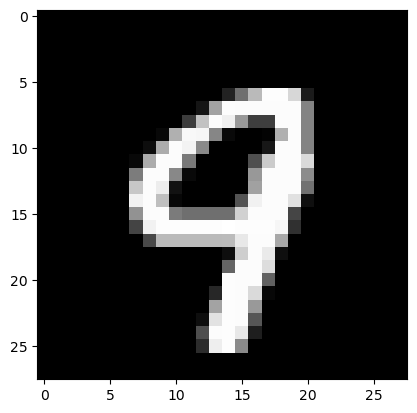

In [49]:
plt.imshow(cln_data[0][0], cmap="gray")
print(true_label[0])

In [53]:
optimizer = optim.Adam(net.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
for e in range(5):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net.train()
    for i, data in enumerate(trainloader):
        imgs, labels = data

        n_b = labels.shape[0]

        outputs = net(imgs)
        loss = criterion(outputs, labels)

        acc = np.sum(np.equal(np.argmax(outputs.data.numpy(), axis=-1), labels.data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp
    print(f"[{e +1}, {i+1:5d}] loss: {loss_avg:.3f}, accuracy: {acc_avg:.3f}")

[1, 10000] loss: 0.024, accuracy: 0.992
[2, 10000] loss: 0.021, accuracy: 0.993
[3, 10000] loss: 0.019, accuracy: 0.993
[4, 10000] loss: 0.018, accuracy: 0.994
[5, 10000] loss: 0.017, accuracy: 0.994
